In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18,12)})

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
data_train = pd.read_excel("train_data.xlsx")
data_predict = pd.read_excel("predict_data.xlsx")
data_train.replace("–|-", np.nan, regex=True, inplace=True)
data_predict.replace("–|-", np.nan, regex=True, inplace=True)

Есть 2 набора данных: **train** и **predict**. В train есть информация и по водным показателям, и по донным (разделяются на **_h* и **_l* - отобраны на разных глубинах). В predict есть информация только по водным показателям. Задача -- предсказать донные по водным на датасете predict, обучив модель перед этим на train.

In [4]:
data_predict.head()

,pH,electricity,Ca,Mg,Na,K,HCO3,SO4,Cl,mineralisation,alkalinity,colour,NH4,NO3,N,PO4,P,Fe
0,7.01,36,4.26,0.74,1.36,0.24,14.2,3.77,0.97,25.5,232,28,14,3,117,0,2,43
1,6.66,29,1.87,0.77,1.71,0.35,7.32,3.84,1.08,16.9,120,77,NaN,7,252,3,8,82
2,7.08,31,3.21,0.77,1.63,0.36,13.2,2.90,0.90,22.9,216,30,10,16,159,1,5,33
3,6.09,20,1.45,0.66,1.22,0.31,11.2,2.00,1.00,12.2,184,31,19,3,199,0,7,71
4,5.23,10,0.47,0.18,0.59,0.15,NaN,2.30,0.80,4.5,NaN,3,26,1,166,1,6,15


In [5]:
data_train.head()

,pH,electricity,Ca,Mg,Na,K,HCO3,SO4,Cl,mineralisation,...,As_h,Hg_h,Cu_l,Ni_l,Zn_l,Co_l,Cd_l,Pb_l,As_l,Hg_l
0,6.87,33,2.13,0.82,3.32,0.64,16.0,1.2,1.3,25.4,...,2.01,0.077,8.1,7.0,98.0,4.3,0.14,0.79,1.68,0.014
1,7.59,135,3.95,0.36,21.30,5.50,38.6,18.3,2.6,90.6,...,NaN,NaN,94.0,9.8,54.0,4.6,0.80,4.20,NaN,NaN
2,6.44,13,0.40,0.20,1.64,0.34,2.9,1.4,1.3,8.1,...,NaN,0.150,12.0,16.0,125.0,11.6,0.14,3.62,NaN,0.051
3,6.82,35,2.23,0.87,3.14,0.71,15.6,1.3,1.7,25.5,...,5.73,0.119,8.7,5.6,58.0,6.7,0.12,1.90,4.78,0.058
4,5.75,14,0.45,0.36,1.42,0.23,1.2,1.3,1.7,6.5,...,3.02,0.078,48.0,28.0,108.0,9.7,0.26,0.99,1.68,0.054


In [6]:
data_train.shape

(92, 34)

In [7]:
data_predict.shape

(428, 18)

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 34 columns):
pH                92 non-null float64
electricity       92 non-null int64
Ca                92 non-null float64
Mg                92 non-null float64
Na                92 non-null float64
K                 92 non-null float64
HCO3              92 non-null float64
SO4               92 non-null float64
Cl                92 non-null float64
mineralisation    92 non-null float64
alkalinity        92 non-null int64
colour            92 non-null int64
NH4               82 non-null object
NO3               92 non-null int64
N                 92 non-null int64
PO4               91 non-null object
P                 91 non-null object
Fe                92 non-null int64
Cu_h              92 non-null float64
Ni_h              92 non-null float64
Zn_h              92 non-null float64
Co_h              92 non-null float64
Cd_h              91 non-null object
Pb_h              92 non-null float64
A

In [9]:
data_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 18 columns):
pH                428 non-null float64
electricity       421 non-null object
Ca                428 non-null object
Mg                427 non-null object
Na                428 non-null float64
K                 428 non-null float64
HCO3              427 non-null object
SO4               428 non-null float64
Cl                428 non-null float64
mineralisation    428 non-null float64
alkalinity        427 non-null object
colour            420 non-null object
NH4               375 non-null object
NO3               421 non-null object
N                 405 non-null object
PO4               406 non-null object
P                 416 non-null object
Fe                423 non-null object
dtypes: float64(6), object(12)
memory usage: 40.2+ KB


Переведём всё в числа. Посчитаем пропущенные значения, запишем вместо них медиану.

In [10]:
data_train = data_train.apply(lambda x: x.astype(float))
data_train.isnull().sum()

pH                 0
electricity        0
Ca                 0
Mg                 0
Na                 0
K                  0
HCO3               0
SO4                0
Cl                 0
mineralisation     0
alkalinity         0
colour             0
NH4               10
NO3                0
N                  0
PO4                1
P                  1
Fe                 0
Cu_h               0
Ni_h               0
Zn_h               0
Co_h               0
Cd_h               1
Pb_h               0
As_h              36
Hg_h              30
Cu_l               0
Ni_l               0
Zn_l               0
Co_l               0
Cd_l               1
Pb_l               0
As_l              37
Hg_l              31
dtype: int64

Опустим значения элементов As & Hg (для них много пропусков).

In [11]:
data_train.drop(['As_h', 'Hg_h', 'As_l', 'Hg_l'], axis=1, inplace=True)

In [12]:
data_predict["Ca"] = data_predict["Ca"].apply(lambda x: x.replace(',','.'))
data_predict = data_predict.apply(lambda x: x.astype(float))
data_predict.isnull().sum()

pH                 0
electricity        7
Ca                 0
Mg                 1
Na                 0
K                  0
HCO3               1
SO4                0
Cl                 0
mineralisation     0
alkalinity         1
colour             8
NH4               53
NO3                7
N                 23
PO4               22
P                 12
Fe                 5
dtype: int64

In [13]:
data_train = data_train.apply(lambda x: x.fillna(x.median()),axis=0)
data_predict = data_predict.apply(lambda x: x.fillna(x.median()),axis=0)

In [14]:
data_train.iloc[:,:18].describe()

,pH,electricity,Ca,Mg,Na,K,HCO3,SO4,Cl,mineralisation,alkalinity,colour,NH4,NO3,N,PO4,P,Fe
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,6.715543,60.739130,3.322717,1.159457,7.172174,1.230543,15.317935,9.423043,4.519783,41.981413,251.086957,30.239130,24.086957,171.608696,511.793478,7.978261,19.652174,137.173913
std,0.595823,138.283899,6.769468,1.567850,27.193102,2.284797,21.241249,44.088708,12.001979,98.192002,348.179777,35.371302,31.941706,584.279399,1065.047195,48.185306,72.175219,210.982766
min,4.640000,8.000000,0.150000,0.010000,0.560000,0.070000,0.060000,0.400000,0.600000,4.000000,1.000000,3.000000,1.000000,1.000000,59.000000,0.000000,2.000000,6.000000
25%,6.495000,24.000000,0.957500,0.435000,1.875000,0.340000,5.272500,1.675000,1.100000,15.850000,86.500000,10.000000,7.000000,2.750000,149.250000,1.000000,5.000000,25.000000
50%,6.740000,36.000000,2.045000,0.820000,2.785000,0.560000,9.750000,2.450000,1.700000,24.950000,160.000000,18.000000,14.500000,14.000000,248.500000,1.000000,8.000000,61.500000
75%,6.987500,54.250000,2.857500,1.290000,6.137500,0.920000,17.850000,4.200000,2.925000,35.800000,291.750000,38.250000,24.000000,55.500000,425.000000,2.000000,13.250000,124.500000
max,8.850000,1296.000000,60.000000,10.900000,262.100000,17.000000,166.500000,418.200000,111.500000,908.500000,2728.000000,245.000000,188.000000,3507.000000,8107.000000,445.000000,670.000000,1260.000000


In [15]:
data_train.iloc[:,18:].describe()

,Cu_h,Ni_h,Zn_h,Co_h,Cd_h,Pb_h,Cu_l,Ni_l,Zn_l,Co_l,Cd_l,Pb_l
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,185.897500,663.907609,105.889130,25.227391,0.798163,20.174674,21.78663,27.569565,82.986957,10.056848,0.320848,4.551630
std,1071.332135,4982.246891,73.277567,71.616618,1.612003,23.011631,16.32370,48.471167,59.535490,7.925865,0.406880,4.990467
min,6.100000,11.000000,11.000000,1.900000,0.020000,1.500000,2.40000,5.000000,16.000000,1.300000,0.010000,0.400000
25%,14.925000,22.000000,58.000000,5.000000,0.200000,6.150000,11.50000,12.300000,41.000000,4.375000,0.080000,1.575000
50%,23.700000,36.500000,97.500000,8.200000,0.390000,12.500000,18.00000,20.000000,73.000000,8.950000,0.170000,3.510000
75%,53.000000,75.250000,132.250000,23.700000,0.737500,25.200000,27.52500,27.250000,100.250000,12.000000,0.302500,5.075000
max,10234.000000,47805.000000,487.000000,661.000000,14.400000,135.600000,94.00000,468.000000,390.000000,53.000000,2.100000,35.100000


In [ ]:
df = np.round(data_train.describe(),2)
df.to_excel(r'C:\Users\Lyasa\Documents\доки\10\1\курсач\project\File Name.xlsx')

## Посмотрим на данные визуально

Картинки лучше смотерть в отдельном окне.

Совместные распределения параметров в датасете для прогнозирования (нет донных):

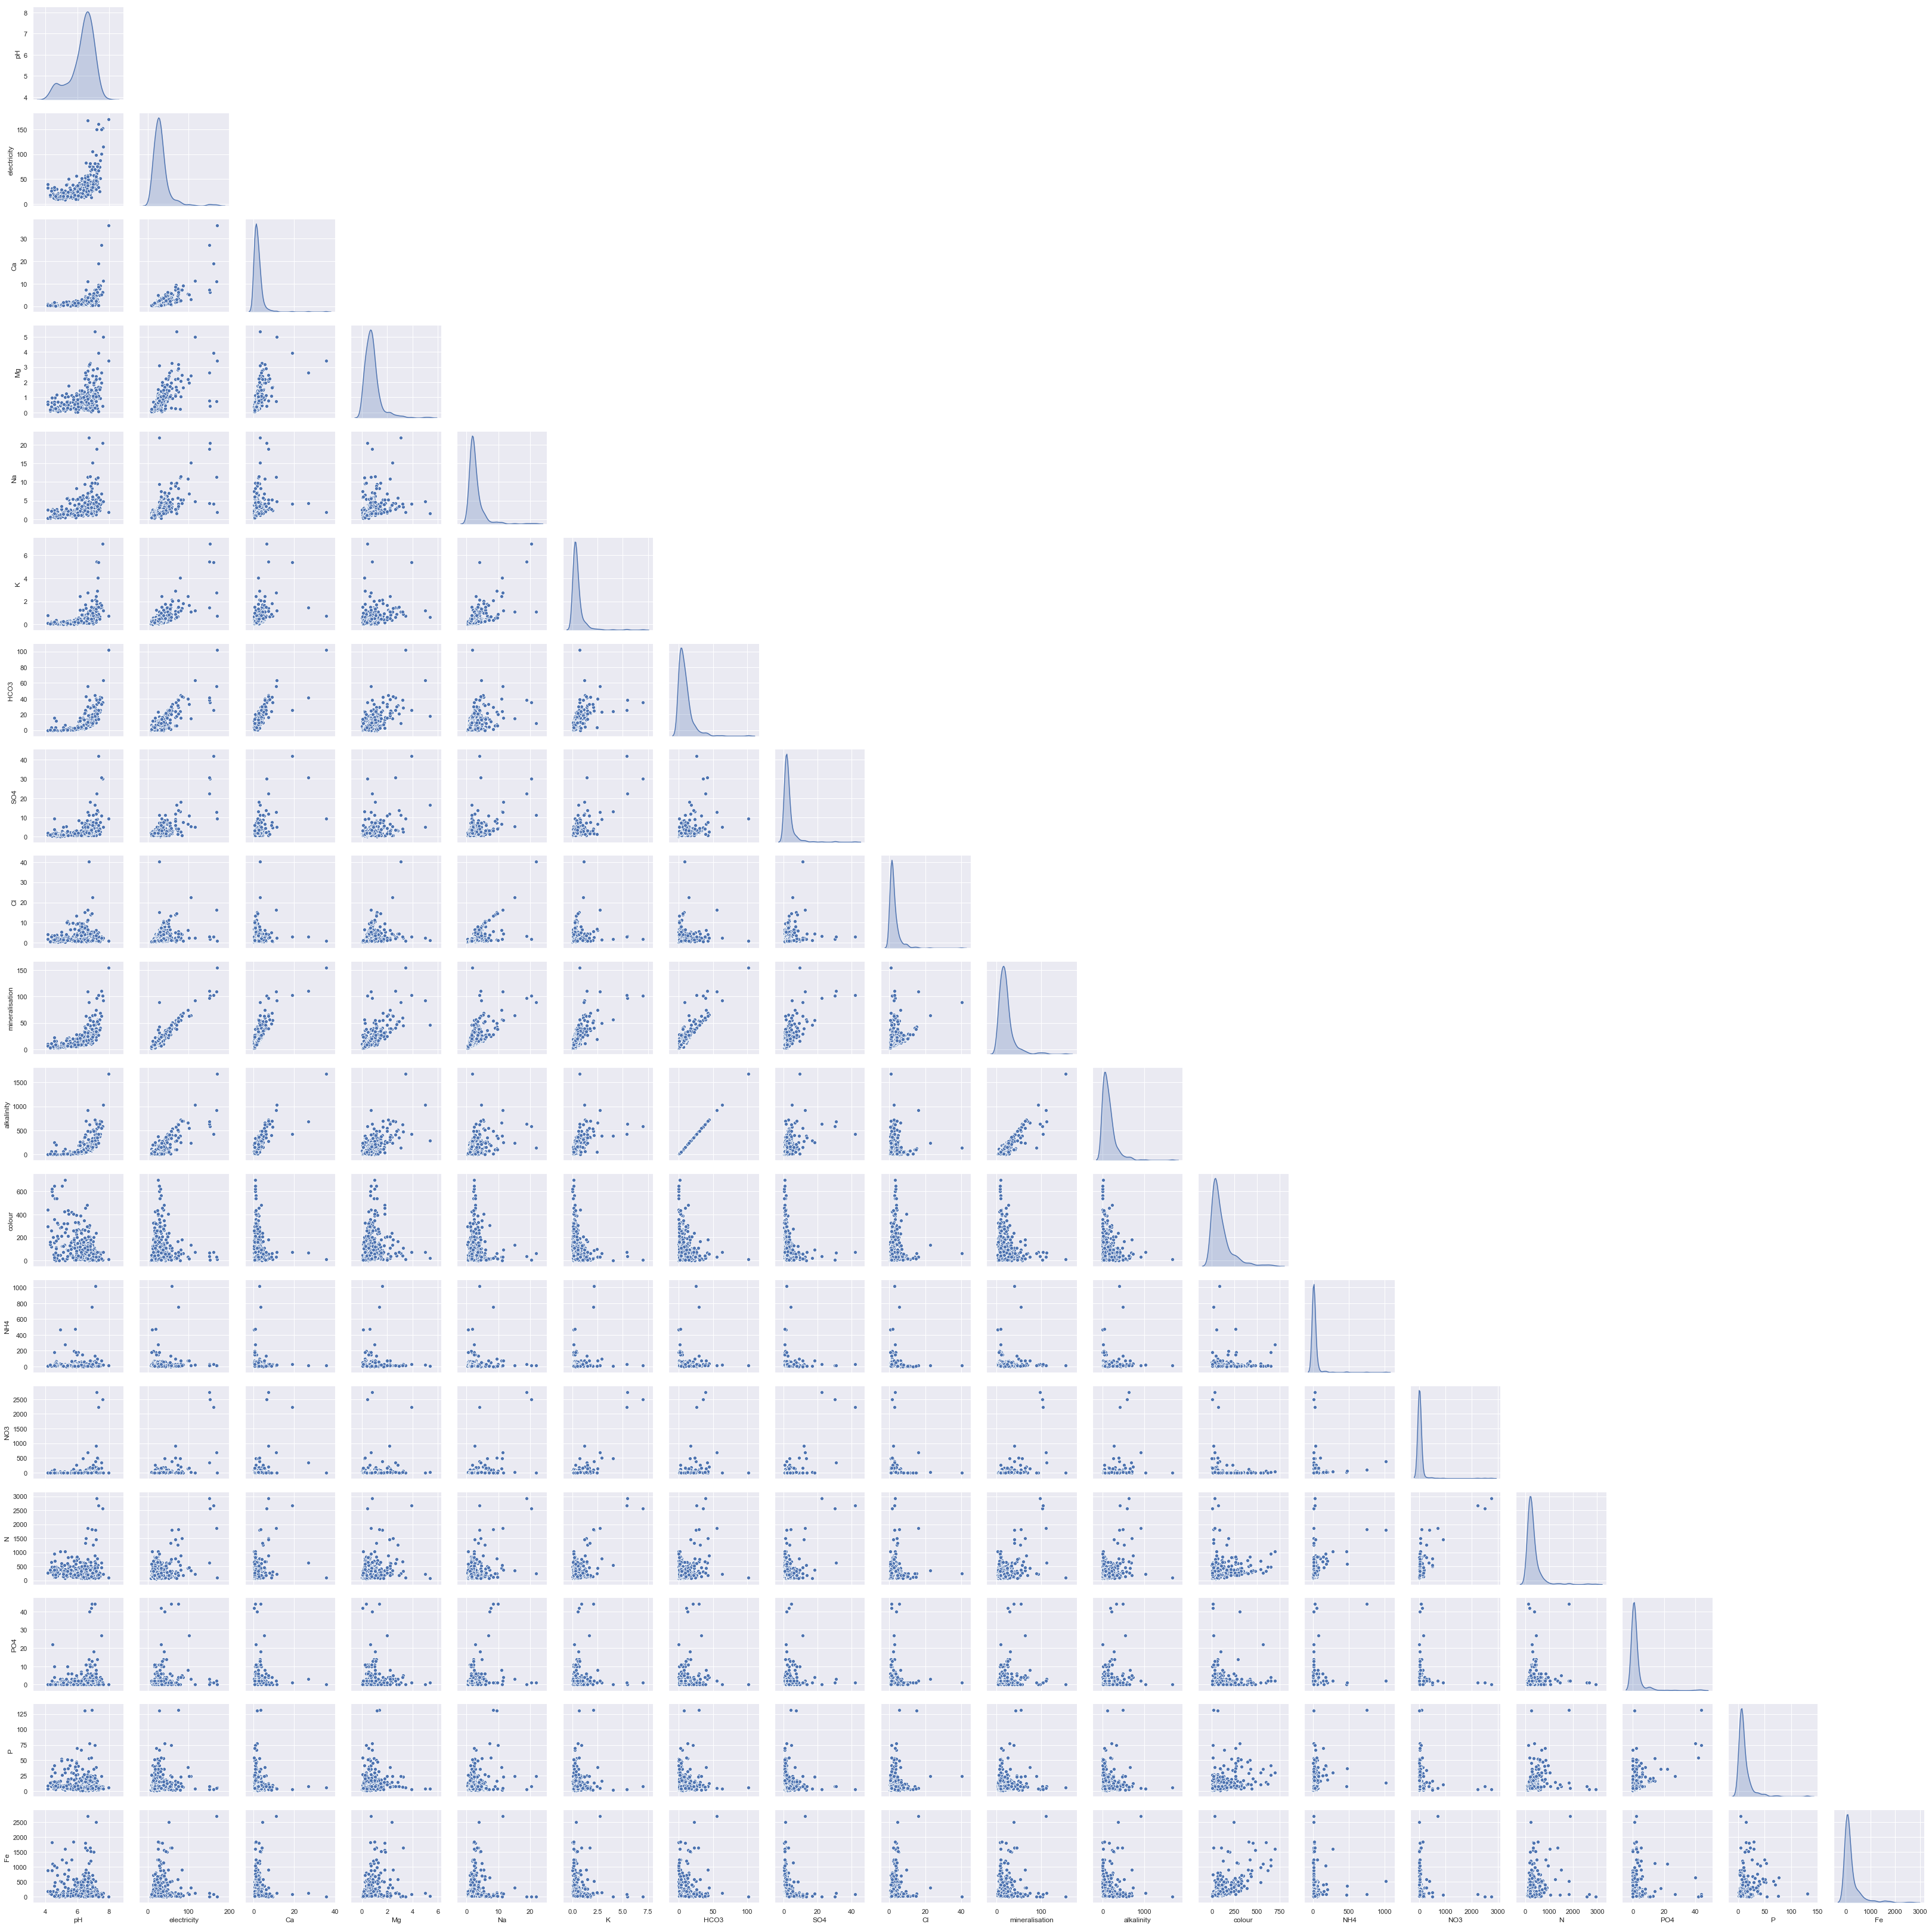

In [16]:
#Scatterplot Matrix
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g = sns.pairplot(data_predict, diag_kind="kde")
g.map_upper(hide_current_axis);

В принципе на данном этапе нам не очень важна структура данных в датасете для прогнозирования. Важнее разобраться с train.

Совместные распределения параметров в датасете для обучения (донные vs водные):

<Figure size 360x360 with 0 Axes>

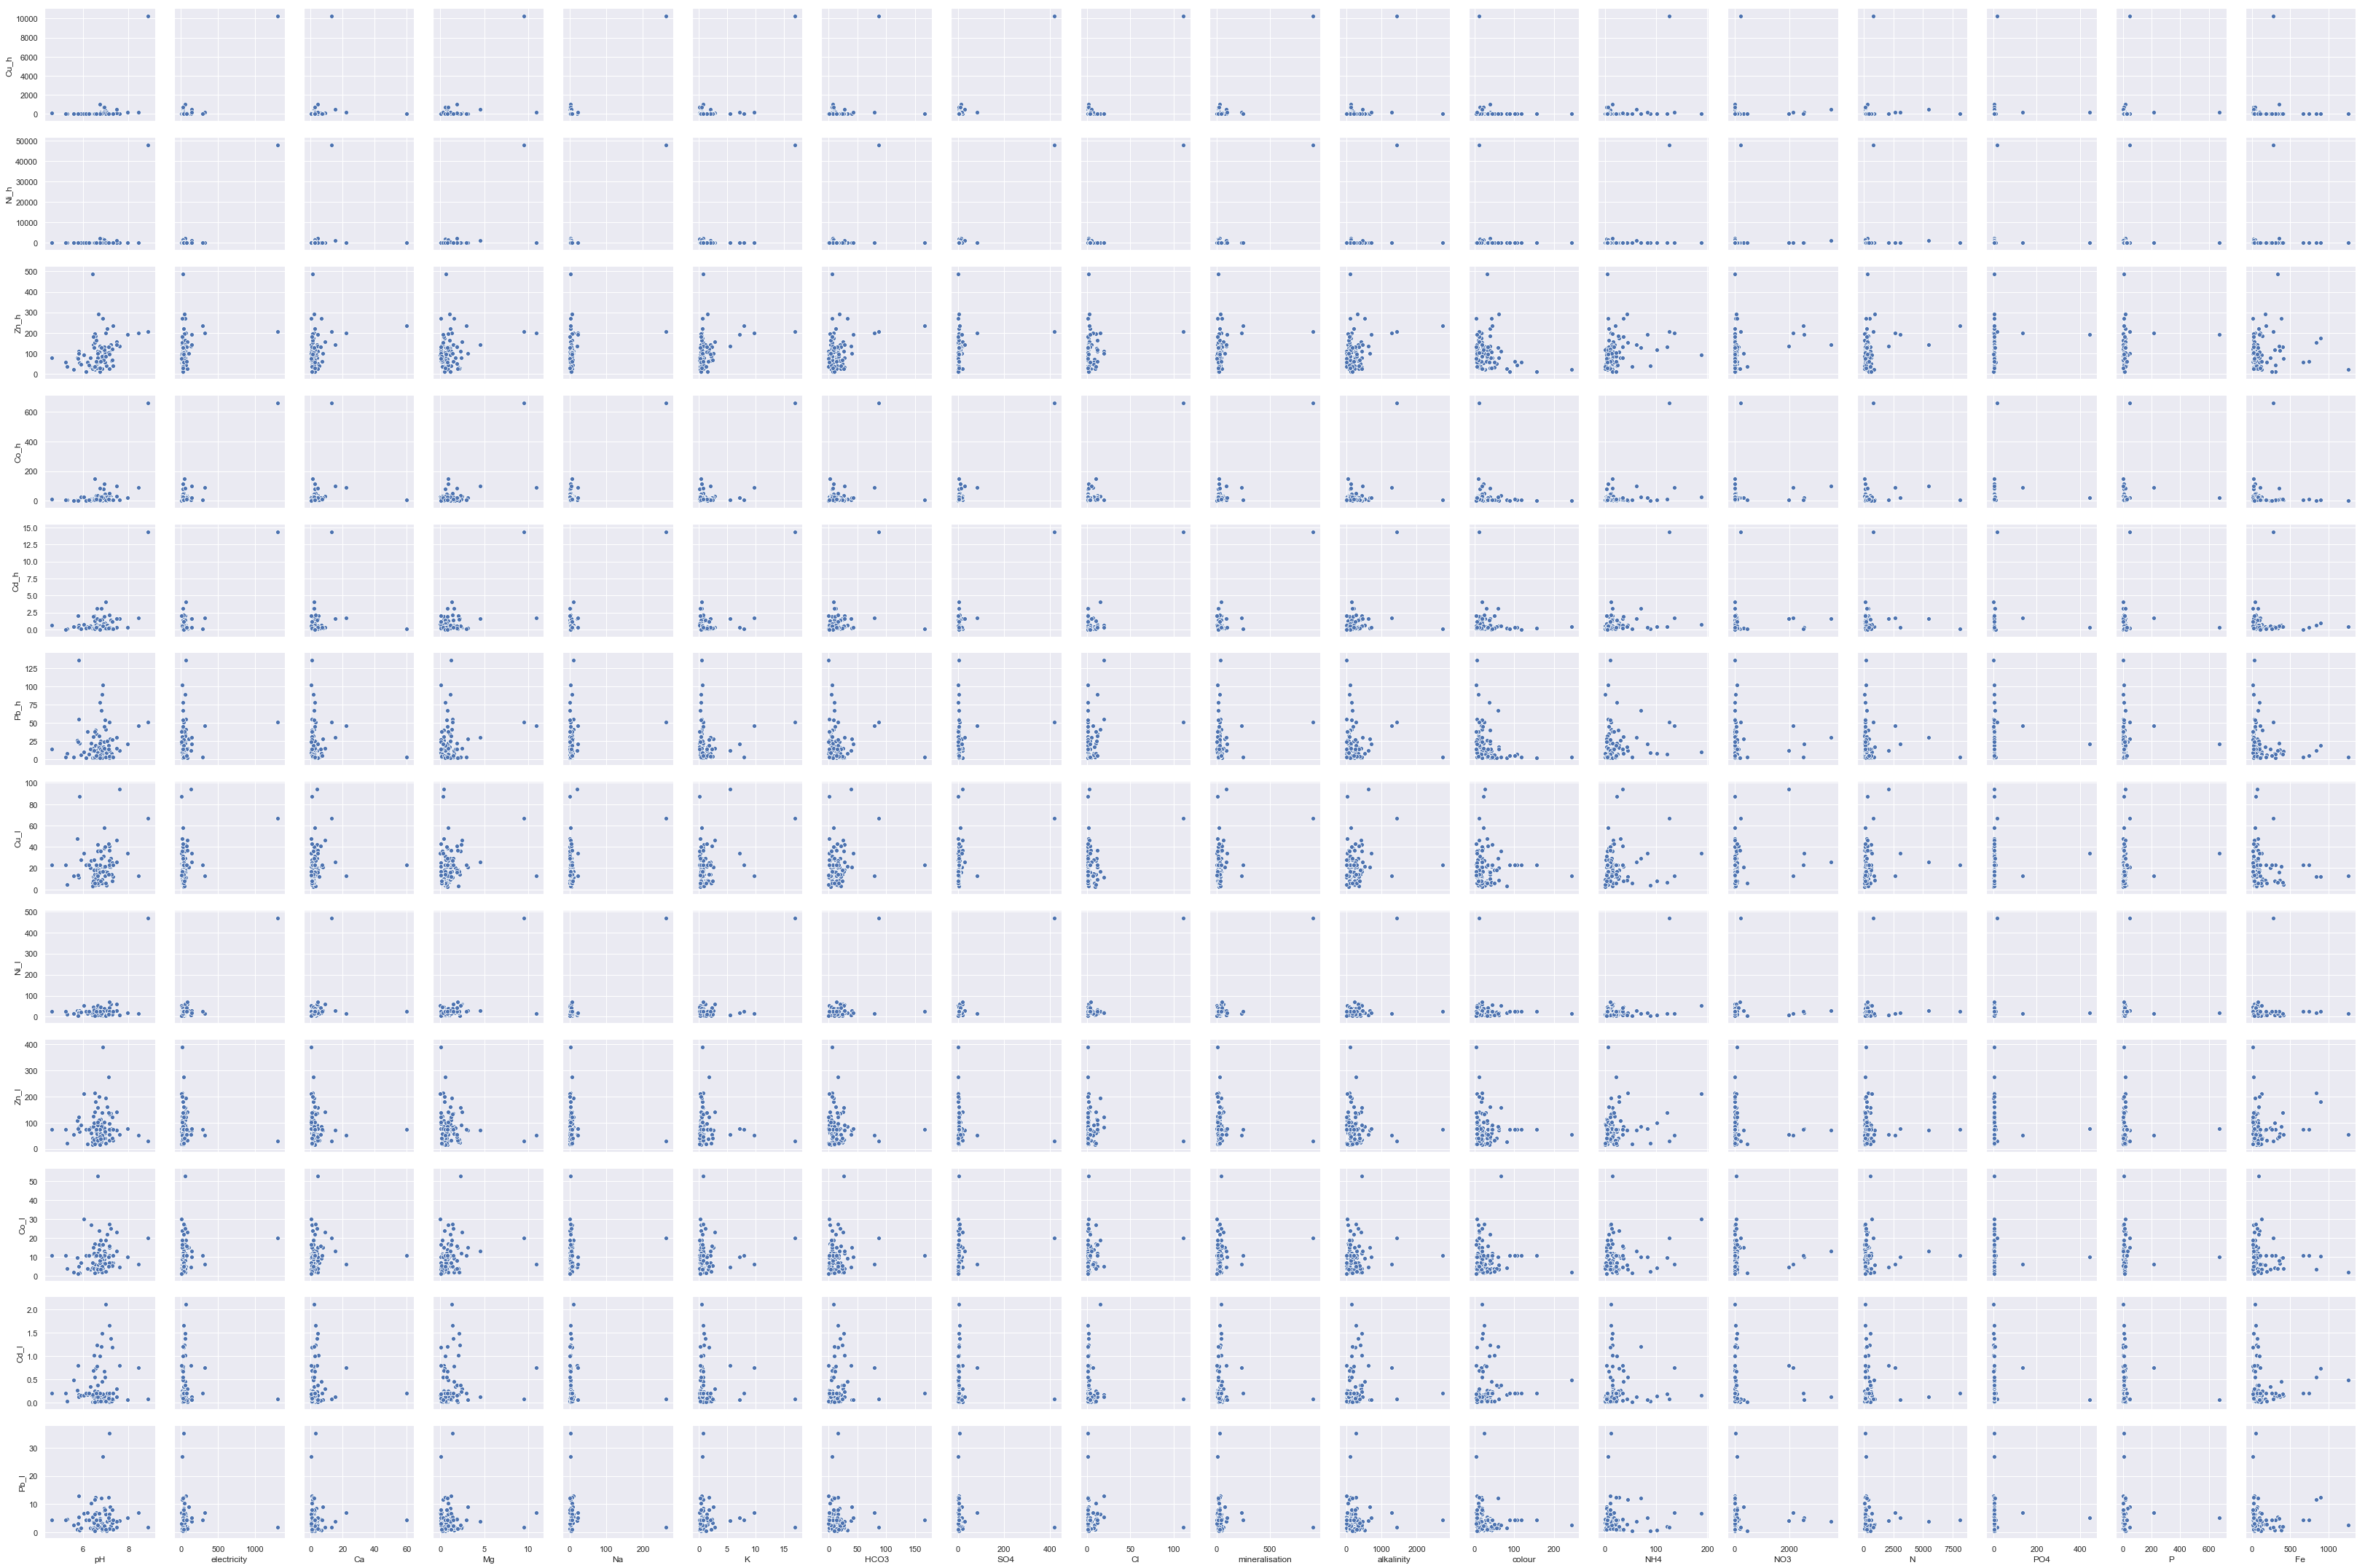

In [18]:
xs = ['pH', 'electricity', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'SO4', 'Cl', 'mineralisation', 'alkalinity', 'colour','NH4', 'NO3', 'N', 'PO4', 'P', 'Fe']
ys = ['Cu_h', 'Ni_h', 'Zn_h', 'Co_h', 'Cd_h', 'Pb_h', 'Cu_l', 'Ni_l', 'Zn_l', 'Co_l', 'Cd_l', 'Pb_l']

plt.figure(figsize = (5,5))
g = sns.pairplot(data_train,
                y_vars=ys,
                x_vars=xs);

Заметно много выбросов по ряду параметров.

Карта корреляции для учебного датасета (с выбросами).

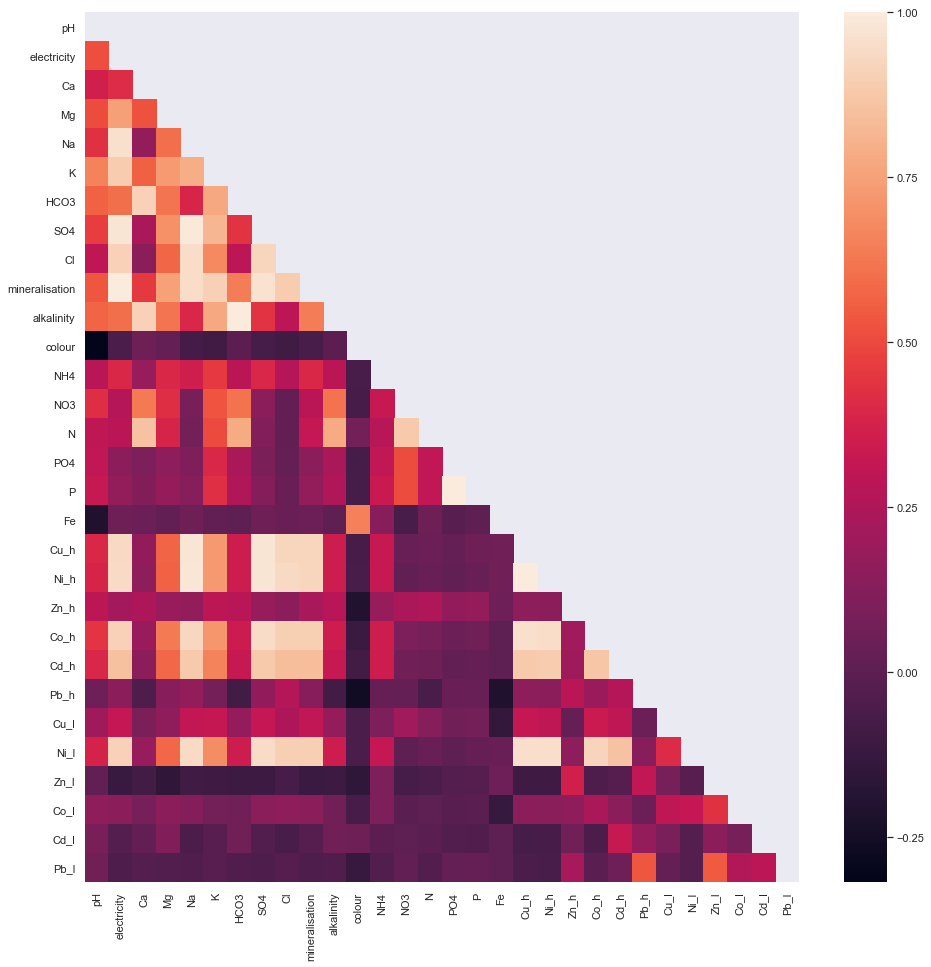

In [19]:
#Correlation heatmap
corr = data_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

А-ха! Смотрим на квадрат: по Х - от начала и до Fe, по У - от Cu_h и до конца. Видим много светлых квадратиков (высокая корреляция). Глянем пример на выбор

Посмотрим на совместное распределение параметров Cu_h и Na с высокой корреляцией:

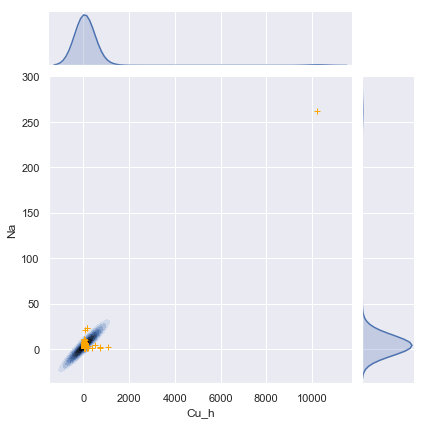

In [20]:
g = sns.jointplot(x="Cu_h", y="Na", data=data_train, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Выглядит уже не так хорошо, как казалось. Попробуем убрать выбросы.

In [21]:
#уберём выбросы (те, что дальше 4-х сигм)
data_train_no_outliers = data_train[(np.abs(stats.zscore(data_train)) < 4).all(axis=1)]
data_train_no_outliers.shape

(77, 30)

<Figure size 360x360 with 0 Axes>

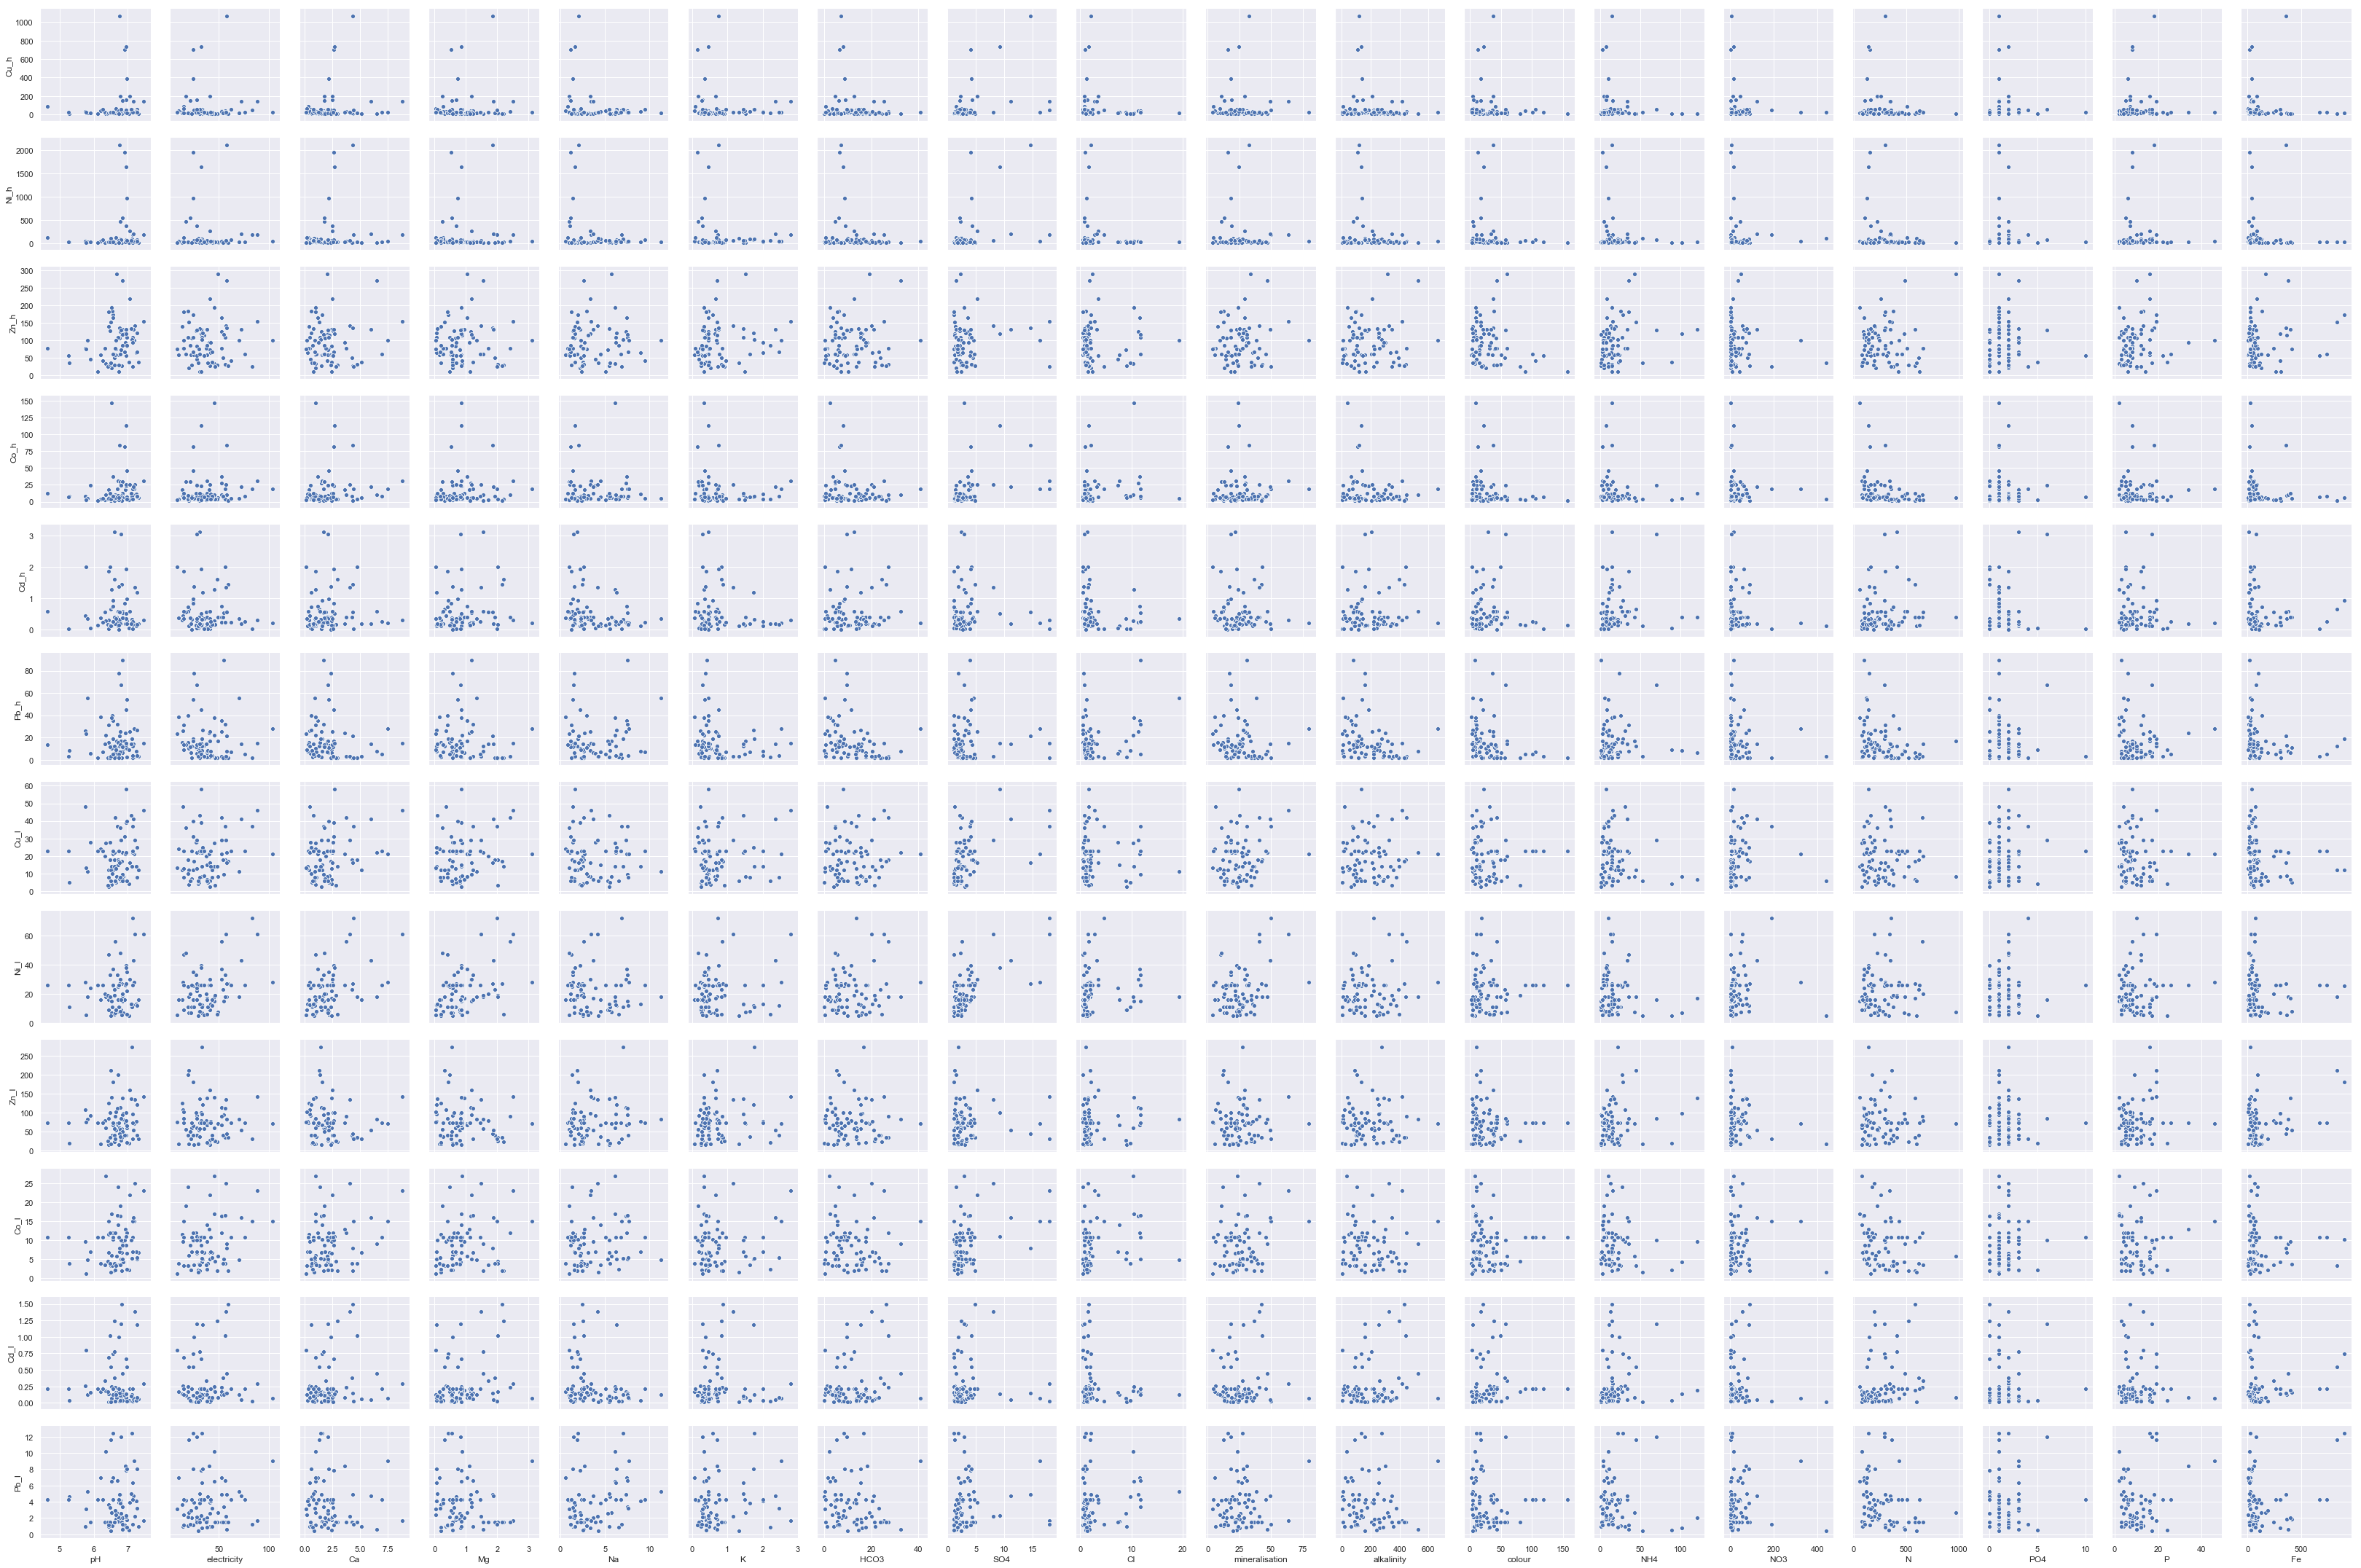

In [22]:
plt.figure(figsize = (5,5))
g = sns.pairplot(data_train_no_outliers,
                y_vars=ys,
                x_vars=xs);

Посмотрим на тот же пример Cu_h и Na, теперь без выбросов:

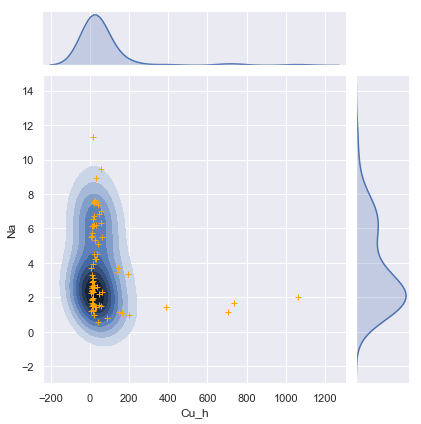

In [23]:
g = sns.jointplot(x="Cu_h", y="Na", data=data_train_no_outliers, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Всё погрустнело.. Посмотрим, что случилось с корреляцией:

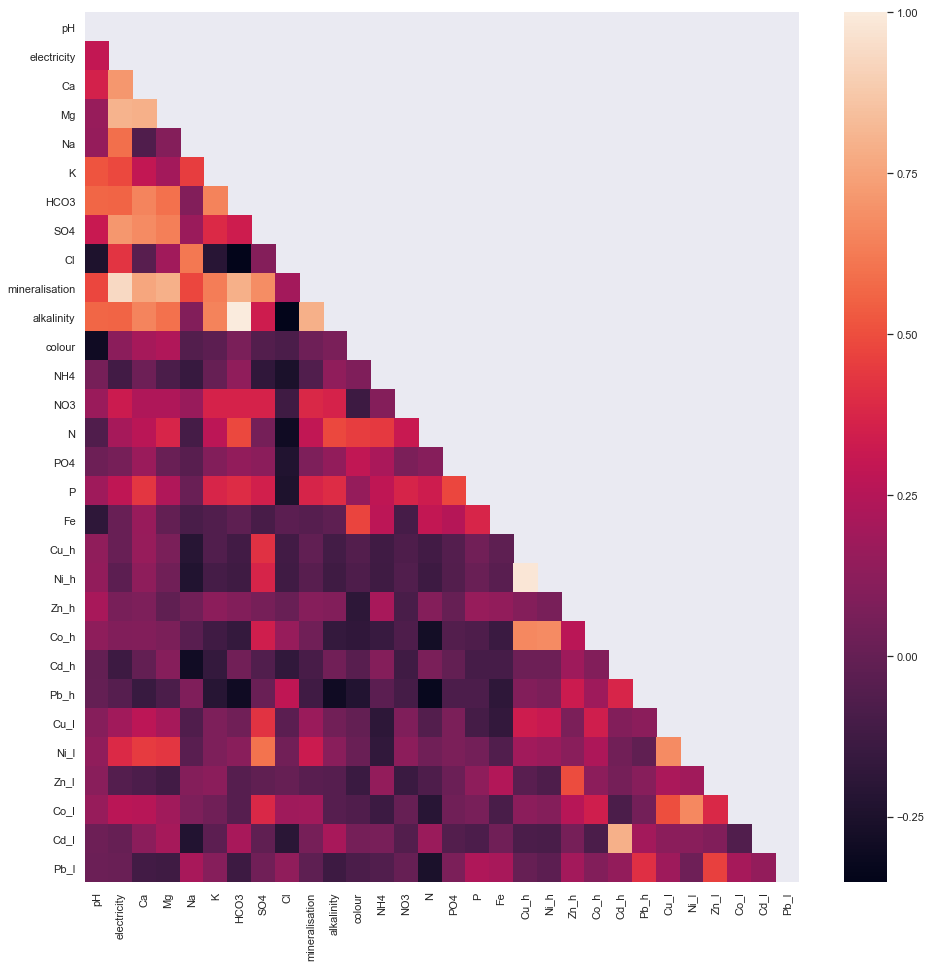

In [24]:
#Correlation heatmap
corr = data_train_no_outliers.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

На нашем квадратике стало темнее. Получается, что высокая корреляция была связана с выбросами (в одном наблюдении было несколько экстремальных значений). Так, но и здесь есть светлое пятно, посмотрим на него повнимательнее:

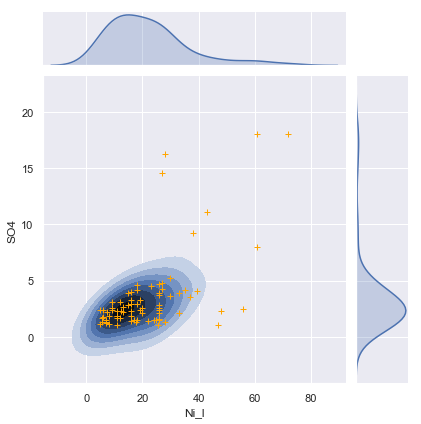

In [25]:
g = sns.jointplot(x="Ni_l", y="SO4", data=data_train_no_outliers, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Получаем **train** датасет из 75 наблюдений, с низкой корреляций между предикторами и прогнозируемыми параметрами.

## Попробуем предсказывать квантили

https://github.com/liquidSVM/liquidSVM/blob/master/bindings/python/demo.ipynb

In [26]:
train, test = train_test_split(data_train, test_size=0.25, random_state=42)

In [27]:
train.shape

(69, 30)

In [28]:
test.shape

(23, 30)

In [29]:
from liquidSVM import *

X -- всё по водным показателям. y -- донные показатели один за другим по очереди.

In [30]:
from sklearn import metrics
import math

In [32]:
quantiles_list = [ 0.05, 0.25, 0.5, 0.75, 0.95 ]

for el in range(18,30):
    X_train, y_train = train.iloc[:,:18], train.iloc[:,el]
    X_test, y_test = test.iloc[:,:18], test.iloc[:,el]
    model = qtSVM(X_train, y_train, weights=quantiles_list)
    y_pred = model.predict(X_test)
    in_p25_p75 = sum(y_pred[:,1] <= y_test) - sum(y_test >= y_pred[:,3])
    in_p05_p95 = sum(y_pred[:,0] <= y_test) - sum(y_test >= y_pred[:,4])
    print(train.columns[el], '\nAccuracy in .25 to .75 =', np.round(in_p25_p75/test.shape[0],2),
          '\nAccuracy in .05 to .95 =', np.round(in_p05_p95/test.shape[0],2), 
          '\nRMSE = ', np.round(math.sqrt(metrics.mean_squared_error(y_test, y_pred[:, 2])),2),
          '\nr^2 = ', np.round(metrics.r2_score(y_test, y_pred[:, 2]),2), '\n\n')

Cu_h 
Accuracy in .25 to .75 = 0.52 
Accuracy in .05 to .95 = 0.91 
RMSE =  2132.6 
r^2 =  -0.05 


Ni_h 
Accuracy in .25 to .75 = 0.52 
Accuracy in .05 to .95 = 0.91 
RMSE =  9964.78 
r^2 =  -0.05 


Zn_h 
Accuracy in .25 to .75 = 0.52 
Accuracy in .05 to .95 = 0.87 
RMSE =  65.79 
r^2 =  -0.04 


Co_h 
Accuracy in .25 to .75 = 0.26 
Accuracy in .05 to .95 = 0.78 
RMSE =  139.09 
r^2 =  -0.09 


Cd_h 
Accuracy in .25 to .75 = 0.57 
Accuracy in .05 to .95 = 0.91 
RMSE =  2.98 
r^2 =  -0.08 


Pb_h 
Accuracy in .25 to .75 = 0.3 
Accuracy in .05 to .95 = 0.83 
RMSE =  25.84 
r^2 =  -0.17 


Cu_l 
Accuracy in .25 to .75 = 0.48 
Accuracy in .05 to .95 = 0.74 
RMSE =  22.3 
r^2 =  -0.21 


Ni_l 
Accuracy in .25 to .75 = 0.39 
Accuracy in .05 to .95 = 0.83 
RMSE =  94.87 
r^2 =  -0.08 


Zn_l 
Accuracy in .25 to .75 = 0.48 
Accuracy in .05 to .95 = 0.87 
RMSE =  79.95 
r^2 =  -0.11 


Co_l 
Accuracy in .25 to .75 = 0.35 
Accuracy in .05 to .95 = 0.78 
RMSE =  12.21 
r^2 =  -0.12 


Cd_l 
Acc